In [52]:
import pandas as pd
import os
import importlib
import clean_gene_name  # import the module first
importlib.reload(clean_gene_name)  # reload the module
from clean_gene_name import clean_gene_name  # re-import the updated function

# Load expression_df
path = ('/Users/atanugiri/.cache/kagglehub/datasets/mahdiehhajian/'
'gene-expression-in-gastric-cancer/versions/1')

# Full file path
file_path = os.path.join(path, 'expression profile(8863 genes).csv')

# Read the CSV and set first column as index
expression_df = pd.read_csv(file_path, index_col=0)

# Preview
print(expression_df.head(2))
print(expression_df.shape)


# Load clinical_df
file_path = 'tcga_gdc_clinical_data.tsv'
columns_to_use = ['Sample ID', 'Diagnosis Age', 'Disease Free (Months)', 
                 'Disease Free Status', 'Fraction Genome Altered', 'ICD-10 Classification',
                 'Mutation Count', 'Overall Survival (Months)', 'Overall Survival Status',
                 'AJCC Pathologic M-Stage', 'AJCC Pathologic N-Stage', 'AJCC Pathologic Stage',
                 'AJCC Pathologic T-Stage', 'Race Category', 'Sex']
# Read the file with tab separator and selected columns
clinical_df = pd.read_csv(file_path, sep='\t', usecols=columns_to_use)

## Convert status to numeric
status_map = {'0:LIVING': 0, '1:DECEASED': 1}
clinical_df["Overall Survival Status"] = clinical_df["Overall Survival Status"].map(status_map)

# Preview the data
print(clinical_df.head(n=2))
print(clinical_df.shape)

       TCGA-BR-4279-01  TCGA-VQ-A94T-01  TCGA-BR-8589-01  TCGA-BR-A4IV-01  \
A1CF           10.4647           6.6146          10.4016           4.6554   
A2ML1           0.0000           4.3985           2.4817           1.3475   

       TCGA-VQ-A8E2-01  TCGA-BR-8297-01  TCGA-D7-A4YY-01  TCGA-BR-4280-01  \
A1CF            9.8054           4.7419           5.1548          10.5675   
A2ML1           3.4159           2.4948           6.3345           0.0000   

       TCGA-D7-A74A-01  TCGA-F1-6177-01  ...  GTEX-QV44-1226-SM-4R1KE  \
A1CF            9.4567          10.7863  ...                   5.7464   
A2ML1           6.7217           0.0000  ...                   3.5820   

       GTEX-13PVQ-2126-SM-5L3FW  GTEX-SNMC-0626-SM-4DM6H  \
A1CF                     3.5094                   5.3059   
A2ML1                    3.3348                   4.4367   

       GTEX-WZTO-2126-SM-4PQYW  GTEX-Q2AH-1126-SM-48TZM  \
A1CF                    3.2506                   5.4593   
A2ML1            

In [66]:
# Step 1: Clean and align patient IDs
expression_df.columns = expression_df.columns.str.strip().str.upper()
clinical_df["Sample ID"] = clinical_df["Sample ID"].str.strip().str.upper()

# Step 2: Find common samples
common_samples = expression_df.columns.intersection(clinical_df["Sample ID"])
print(common_samples)
print(len(common_samples))

# Step 3: Subset both datasets to common patients
expression_df = expression_df[common_samples]
clinical_df = clinical_df[clinical_df["Sample ID"].isin(common_samples)]

# Step 4: Reorder clinical_df to match column order of expression_df
clinical_df = clinical_df.set_index("Sample ID").loc[common_samples].reset_index()

# Step 5: Rename "index" back to "Sample ID"
clinical_df.rename(columns={"index": "Sample ID"}, inplace=True)

print(f"expression_df shape: {expression_df.shape}")
print(f"expression_df shape: {clinical_df.shape}")

Index(['TCGA-BR-4279-01', 'TCGA-VQ-A94T-01', 'TCGA-BR-8589-01',
       'TCGA-BR-A4IV-01', 'TCGA-VQ-A8E2-01', 'TCGA-BR-8297-01',
       'TCGA-D7-A4YY-01', 'TCGA-BR-4280-01', 'TCGA-D7-A74A-01',
       'TCGA-F1-6177-01',
       ...
       'TCGA-VQ-A92D-01', 'TCGA-HU-A4H0-01', 'TCGA-RD-A7BW-01',
       'TCGA-BR-8686-01', 'TCGA-BR-4256-01', 'TCGA-D7-8576-01',
       'TCGA-VQ-A8DT-01', 'TCGA-BR-4363-01', 'TCGA-CD-A486-01',
       'TCGA-HU-A4G6-01'],
      dtype='object', length=413)
413
expression_df shape: (8863, 413)
expression_df shape: (413, 15)


### Sanity check

In [67]:
assert all(expression_df.columns == clinical_df["Sample ID"])
print("Expression data and clinical metadata are aligned!")

Expression data and clinical metadata are aligned!


Next Step: What You Can Do
From here, you can go in different directions:

🧪 Option A: Differential Expression

Compare gene expression between:

Alive vs. Dead
Male vs. Female
Cancer stages (e.g., Stage I vs Stage IV)
📉 Option B: PCA (Principal Component Analysis)

Reduce 8863 genes → 2 or 3 axes to see sample clusters

🧠 Option C: Correlate genes with clinical values

Example: higher TP53 → lower survival time?

### Routine
Top variable genes are a great starting point for:

Plotting expression patterns
PCA/UMAP dimensionality reduction
Filtering out low-signal genes

## Order genes by expression by 

In [71]:
gene_variance = expression_df.var(axis=1).sort_values(ascending=False)
top_genes = gene_variance.head(20).index
top_genes

Index(['LIPF', 'PGA3', 'XIST', 'GKN1', 'PGA4', 'RPS4Y1', 'MAGEA3', 'PGC',
       'DAZ1', 'MAGEA6', 'BPIFB1', 'DDX3Y', 'GKN2', 'OLFM4', 'KDM5D',
       'RP11-205M5.3', 'MUC5AC', 'CTD-2369P2.12', 'MUC6', 'FABP1'],
      dtype='object')

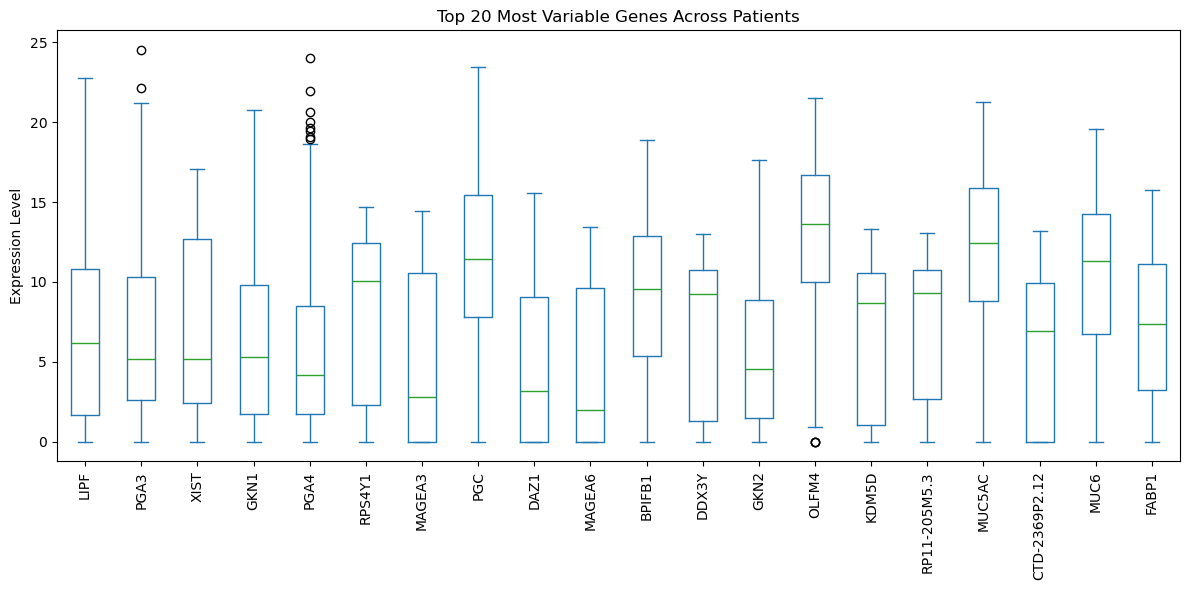

In [72]:
import matplotlib.pyplot as plt

# Transpose to shape: (patients, genes)
expression_df.loc[top_genes].T.plot(kind='box', figsize=(12, 6))

plt.title("Top 20 Most Variable Genes Across Patients")
plt.ylabel("Expression Level")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [73]:
# Get variance ranking of CD36
cd36_variance = expression_df.var(axis=1).loc["CD36"]
rank = expression_df.var(axis=1).rank(ascending=False).loc["CD36"]
print(f"CD36 variance: {cd36_variance:.4f}, Rank: {int(rank)} out of {expression_df.shape[0]}")

CD36 variance: 2.3162, Rank: 3870 out of 8863


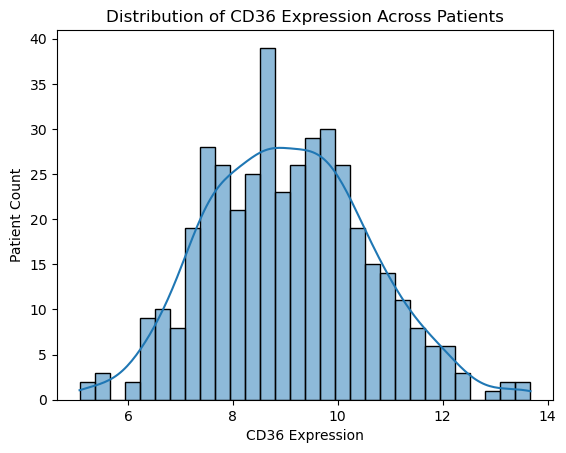

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(expression_df.loc["CD36"], bins=30, kde=True)
plt.title("Distribution of CD36 Expression Across Patients")
plt.xlabel("CD36 Expression")
plt.ylabel("Patient Count")
plt.show()

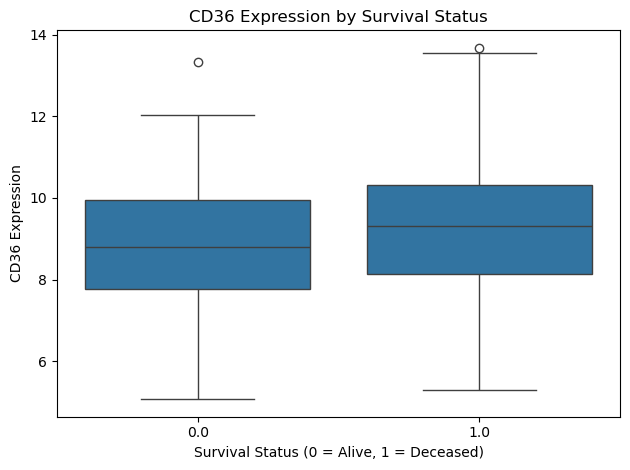

In [75]:
# Only use already-aligned expression_df and clinical_df (with 413 columns/rows)
cd36_expr = expression_df.loc["CD36"]  # length 413
plot_df = clinical_df.copy()           # also 413 rows

# Assign CD36 expression to clinical_df
plot_df["CD36 Expression"] = cd36_expr.values

# Drop rows with any missing values
plot_df = plot_df.dropna(subset=["Overall Survival Status", "CD36 Expression"])

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x="Overall Survival Status", y="CD36 Expression", data=plot_df)
plt.xlabel("Survival Status (0 = Alive, 1 = Deceased)")
plt.ylabel("CD36 Expression")
plt.title("CD36 Expression by Survival Status")
plt.tight_layout()
plt.show()


In [76]:
from scipy.stats import ttest_ind

alive_vals = plot_df[plot_df["Overall Survival Status"] == 0]["CD36 Expression"]
dead_vals = plot_df[plot_df["Overall Survival Status"] == 1]["CD36 Expression"]

t_stat, p_val = ttest_ind(alive_vals, dead_vals, equal_var=False)
print(f"CD36 Expression: t = {t_stat:.3f}, p = {p_val:.4f}")

CD36 Expression: t = -2.743, p = 0.0064


## Next: Identify Differentially Expressed Genes

### Let's start by comparing gene expression between Alive (0) and Deceased (1) patients to find genes that might be related to survival outcome.

In [51]:
from scipy.stats import ttest_ind
import pandas as pd

# Extract survival labels
survival_status = clinical_df["Overall Survival Status"]

# Get indices (column names) for alive and deceased patients
alive_ids = clinical_df[survival_status == 0]["Sample ID"]
dead_ids = clinical_df[survival_status == 1]["Sample ID"]

# Perform t-test for each gene
pvals = []
for gene in expression_df.index:
    group1 = expression_df.loc[gene, alive_ids]
    group2 = expression_df.loc[gene, dead_ids]
    
    # Use Welch’s t-test (does not assume equal variance)
    t_stat, p_val = ttest_ind(group1, group2, nan_policy='omit', equal_var=False)
    pvals.append(p_val)

# Store results
results_df = pd.DataFrame({
    "Gene": expression_df.index,
    "p-value": pvals
}).sort_values("p-value")

# Show top hits
print(results_df.head(10))

               Gene   p-value
5862  RP11-136C24.3  0.000006
4953         PAPPA2  0.000033
2966        GOLGA8T  0.000038
7451       SERPINE1  0.000045
3021           GPX3  0.000046
8428         TUBB4A  0.000051
421          ADGRD1  0.000054
5045           PER1  0.000059
7694      SMIM10L2B  0.000072
714        ARHGAP10  0.000073


In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.boxplot(x=clinical_df["Overall Survival Status"], y=expression_df.loc["CD36"])
# plt.xlabel("Survival Status (0=Alive, 1=Deceased)")
# plt.ylabel("CD36 Expression")
# plt.title("CD36 Expression by Survival Status in Gastric Cancer")
# plt.show()

TypeError: bar() missing 1 required positional argument: 'height'